In [3]:
from pandas import DataFrame, Grouper
import pandas as pd
import numpy as np
from datetime import datetime
import sys
import world_bank_data as wb
import seaborn as sns
import matplotlib.pyplot as plt


In [9]:
# import our own stuff
sys.path.append("../python/src")

from worldbankApi import get_regionnames, fetch_series, default_series, get_all_countries


In [10]:
# set some options
pd.set_option('display.max_rows', 600)
pd.set_option('display.max_columns', 600)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

datadir = "../data/"
cachedir = "../data/cache" 

In [11]:
#wb.search_indicators('water')

In [12]:
mdg_series = {
    'ER.H2O.FWTL.ZS': 'Annual freshwater withdrawals, total (% of internal resources)',
    'ER.H2O.FWTL.K3': 'Annual freshwater withdrawals, total (billion cubic meters)',
    'ER.H2O.FWST.ZS': 'Level of water stress: freshwater withdrawal as a proportion of available freshwater resources',
    'SH.H2O.BASW.ZS': 'People using at least basic drinking water services (% of population)',
    'SG.H2O.TM30.HH.ZS': 'Households with water 30 minutes or longer away round trip (%)',
    'SG.H2O.TL30.HH.ZS': 'Households with water less than 30 minutes away round trip (%)',
    'SG.H2O.PRMS.HH.ZS': 'Households with water on the premises (%)',
    # 'SH.H2O.SAFE.ZS': 'Improved water source (% of population with access)', # not accessibale -> archiv
    'SH.H2O.SMDW.ZS': 'People using safely managed drinking water services (% of population)',
    # 'SH.STA.ACSN': 'Improved sanitation facilities (% of population with access)', #  not accessibale -> archiv
    'SP.POP.TOTL': 'Population, total',
#    'IN.POV.HH.DRNKNGWATER.TOTL.PCT': 'Households Access to Safe Drinking Water - Total (%) (india)', # Country Partnership Strategy for India (FY2013 - 17)
#    'IN.POV.HH.DRKNGWATER.WITHIN': 'Availability of drinking water source within the premises (india)',
#    'IN.POV.HH.DRKNGWATER.NEAR': 'Availability of drinking water source near the premises (india)',
#    'IN.POV.HH.DRKNGWATER.AWAY': 'Availability of drinking water from a source away (india)',
#    'IN.POV.HH.DRKNGWATER': 'Total households with drinking water facility (india)',
    'IE.PPN.WATR.CD': 'Public private partnerships investment in water and sanitation (current US$)',
    'IE.PPI.WATR.CD': 'Investment in water and sanitation with private participation (current US$)',
    'IC.WAT.GIFT.ZS': 'Expected to give gifts to get a water connection (% of firms)',
    'IC.FRM.CORR.CORR7': 'Percent of firms expected to give gifts to get a water connection',
    'IC.WAT.DURS': 'Delay in obtaining a water connections (days)',
    'IC.FRM.INFRA.IN6':'Number of water insufficiencies in a typical month',
#    'HOU.H2O.ACSN.ZS': 'Household Access to Safe Water (in % of total household) (indonesia)',
    'ER.H2O.INTR.PC': 'Renewable internal freshwater resources per capita (cubic meters)',
    'ER.H2O.INTR.K3': 'Renewable internal freshwater resources, total (billion cubic meters)',
#    '5.51.01.09.water': 'Access to water' # usless data
    
}

df = fetch_series(series=mdg_series,date="1999:2018")
countrynames = get_all_countries(cachedir=cachedir,includeaggs=True)
df.rename(columns=mdg_series,inplace=True)
#display(countrynames)


Writing cached_df_file: data/cache/ER.H2O.FWTL.ZS.p
Writing cached_df_file: data/cache/ER.H2O.FWTL.K3.p
Writing cached_df_file: data/cache/ER.H2O.FWST.ZS.p
Writing cached_df_file: data/cache/SH.H2O.BASW.ZS.p
Writing cached_df_file: data/cache/SG.H2O.TM30.HH.ZS.p
Writing cached_df_file: data/cache/SG.H2O.TL30.HH.ZS.p
Writing cached_df_file: data/cache/SG.H2O.PRMS.HH.ZS.p
Writing cached_df_file: data/cache/SH.H2O.SMDW.ZS.p
Writing cached_df_file: data/cache/SP.POP.TOTL.p
Writing cached_df_file: data/cache/IE.PPN.WATR.CD.p
Writing cached_df_file: data/cache/IE.PPI.WATR.CD.p
Writing cached_df_file: data/cache/IC.WAT.GIFT.ZS.p
Writing cached_df_file: data/cache/IC.FRM.CORR.CORR7.p
Writing cached_df_file: data/cache/IC.WAT.DURS.p
Writing cached_df_file: data/cache/IC.FRM.INFRA.IN6.p
Writing cached_df_file: data/cache/ER.H2O.INTR.PC.p
Writing cached_df_file: data/cache/ER.H2O.INTR.K3.p
Writing cached_df_file: ../data/cache/countrycodes.p


In [13]:
# read the historical classification in Incomegroups from the worldbank
icgroup_df = pd.read_csv(datadir+"/OGHIST.csv",header=0,quotechar='"',low_memory=False,sep=";",na_values=['..'])

# the historical data some datapoints
# fill missing values with the value from the next valid year 
# this is a little dirty in code
T = icgroup_df.T
#display(T)
#display(T.describe())
T = T.fillna(method ='backfill') 
#display(T)
#display(T.describe())
icgroup_df = T.T
icgroup_df = icgroup_df.melt(id_vars=('id','Country'),var_name="Year")
#display(icgroup_df.sample())
# replace the values used for classification with the values used by oecd
icgroup_df = icgroup_df.replace({'value': {'L': 'LDCs','LM': 'LMICs', 'UM':'UMICs','H': 'HICs', 'LM*':'LMICs'}})
# give it a nice name
icgroup_df = icgroup_df.rename(columns={'value': 'IncomeGroup'})
# create a mergeable unique feature
icgroup_df['mergefield'] = icgroup_df['Year'].apply(lambda x: str(x))
icgroup_df['mergefield'] = icgroup_df['mergefield'] + icgroup_df['id']
#display(icgroup_df.sample(10))

# create a mergefield within the dataframe 
df['mergefield'] = df['Year']
df['mergefield'] = df['mergefield'] + df['Country']
#display(df.sample())
df = df.merge(icgroup_df.add_prefix("worldbank "),
                       right_on='worldbank mergefield',
                       how="left",left_on='mergefield',indicator=True)
df.drop(columns=['mergefield','worldbank id','worldbank Country',
                'worldbank Year','worldbank mergefield','_merge'],inplace=True)
#display(df.sample(5))

df.replace(countrynames,inplace=True)
display(df.sample(5))

Country  Year  \
1321                                      Euro area  2000   
4160                                    El Salvador  2001   
4220                                         Serbia  2001   
1258  Europe & Central Asia (excluding high income)  2017   
2272                                          Italy  2013   

      Annual freshwater withdrawals, total (% of internal resources)  \
1321                                                             0.0   
4160                                                             0.0   
4220                                                             0.0   
1258                                                             0.0   
2272                                                             0.0   

      Annual freshwater withdrawals, total (billion cubic meters)  \
1321                                                          0.0   
4160                                                          0.0   
4220                                                          0.0   
1258                                                          0.0   
2272                                                          0.0   

      Level of water stress: freshwater withdrawal as a proportion of available freshwater resources  \
1321                                                                                             0.0   
4160                                                                                             0.0   
4220                                                                                             0.0   
1258                                                                                             0.0   
2272                                                                                             0.0   

      People using at least basic drinking water services (% of population)  \
1321                                                              99.717850   
4160                                                              77.994509   
4220                                                              94.714334   
1258                                                              96.167522   
2272                                                              99.487650   

      Households with water 30 minutes or longer away round trip (%)  \
1321                                                             0.0   
4160                                                             0.0   
4220                                                             0.0   
1258                                                             0.0   
2272                                                             0.0   

      Households with water less than 30 minutes away round trip (%)  \
1321                                                             0.0   
4160                                                             0.0   
4220                                                             0.0   
1258                                                             0.0   
2272                                                             0.0   

      Households with water on the premises (%)  \
1321                                        0.0   
4160                                        0.0   
4220                                        0.0   
1258                                        0.0   
2272                                        0.0   

      People using safely managed drinking water services (% of population)  \
1321                                                              95.577421   
4160                                                               0.000000   
4220                                                              74.512235   
1258                                                              77.895909   
2272                                                              93.383708   

      Population, total  \
1321        321310791.0   
4160          5927006.0   


Francesca is exporting herself a nice csv!

In [14]:
# Global view for first grouped streamgraph
df.to_csv('data/Millennium_water_access.csv', sep=',', index=False, na_rep='NaN')

Breaking down the original dataframe by filtering according to `[worldbank IncomeGroup]` column

In [35]:
# Creating array with income groups
incomegroups = df['worldbank IncomeGroup'].unique()

no2018 = df.loc[(df['Year'] != '2018') & (df['Year'] != '1999')]
no2018.head(20)

Country  Year  \
1         Aruba  2000   
2         Aruba  2001   
3         Aruba  2002   
4         Aruba  2003   
5         Aruba  2004   
6         Aruba  2005   
7         Aruba  2006   
8         Aruba  2007   
9         Aruba  2008   
10        Aruba  2009   
11        Aruba  2010   
12        Aruba  2011   
13        Aruba  2012   
14        Aruba  2013   
15        Aruba  2014   
16        Aruba  2015   
17        Aruba  2016   
18        Aruba  2017   
21  Afghanistan  2000   
22  Afghanistan  2001   

    Annual freshwater withdrawals, total (% of internal resources)  \
1                                                              0.0   
2                                                              0.0   
3                                                              0.0   
4                                                              0.0   
5                                                              0.0   
6                                                              0.0   
7                                                              0.0   
8                                                              0.0   
9                                                              0.0   
10                                                             0.0   
11                                                             0.0   
12                                                             0.0   
13                                                             0.0   
14                                                             0.0   
15                                                             0.0   
16                                                             0.0   
17                                                             0.0   
18                                                             0.0   
21                                                             0.0   
22                                                             0.0   

    Annual freshwater withdrawals, total (billion cubic meters)  \
1                                                          0.00   
2                                                          0.00   
3                                                          0.00   
4                                                          0.00   
5                                                          0.00   
6                                                          0.00   
7                                                          0.00   
8                                                          0.00   
9                                                          0.00   
10                                                         0.00   
11                                                         0.00   
12                                                         0.00   
13                                                         0.00   
14                                                         0.00   
15                                                         0.00   
16                                                         0.00   
17                                                         0.00   
18                                                         0.00   
21                                                        20.28   
22                                                         0.00   

    Level of water stress: freshwater withdrawal as a proportion of available freshwater resources  \
1                                                                                              0.0   
2                                                                                              0.0   
3                                                                                              0.0   
4                                                                                              0.0   
5                                                                                            

In [37]:
# Exporting all countries avoiding 1999 and 2018 (always set to zero)
no2018.to_csv('data/Millennium_water_access.csv', sep=',', index=False, na_rep='NaN')

In [42]:
# Looping and exporting
for group in incomegroups:
    filtered = no2018.loc[(no2018['worldbank IncomeGroup'] == group)]
    countries = filtered['Country'].unique()
    filtered.to_csv('data/Millennium_{0}_group.csv'.format(group), sep=',', index=False, na_rep='nan')
    print('{0} done'.format(group))

HICs done
LDCs done
LMICs done
UMICs done
nan done


<AxesSubplot:title={'center':'People not using safely managed drinking water services (absolut)'}, xlabel='Year'>

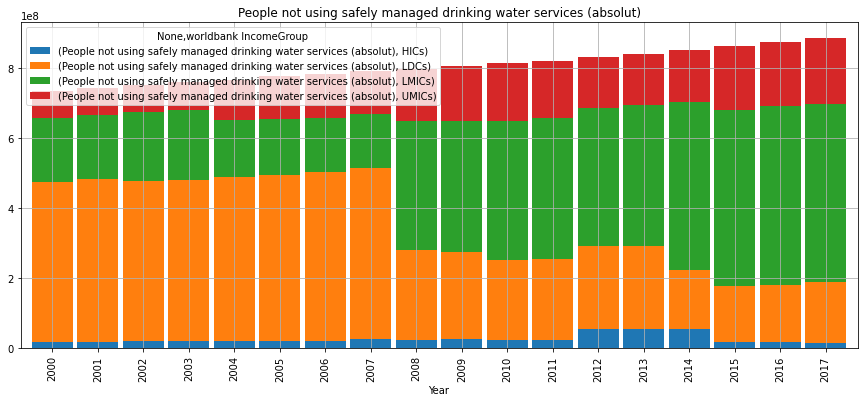

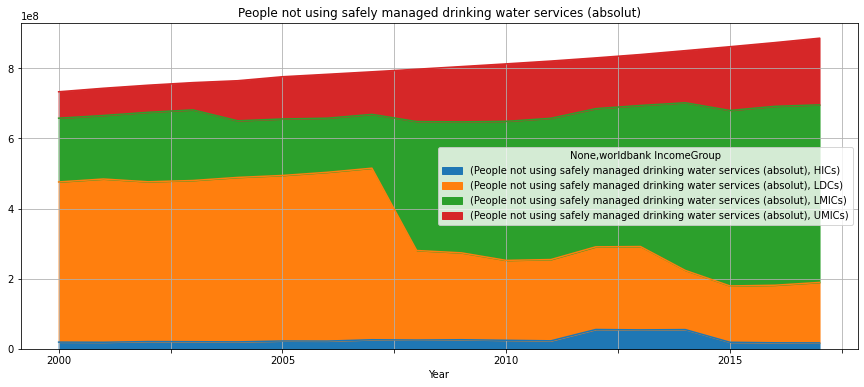

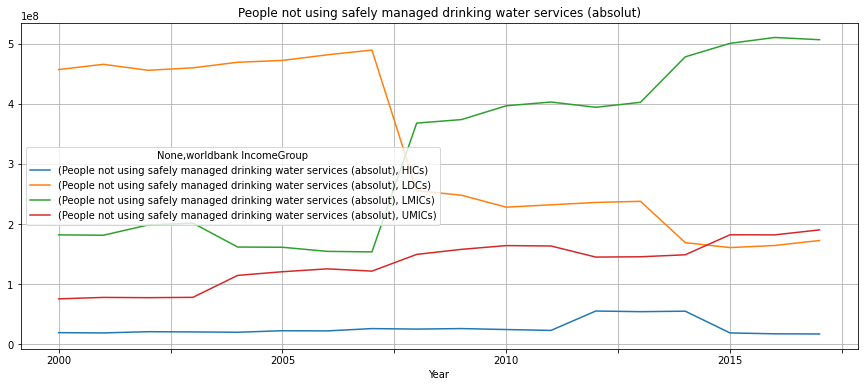

In [7]:
i = 'People using safely managed drinking water services (absolut)'
j = 'People not using safely managed drinking water services (absolut)'
k = 'Population, total'
l = 'People using safely managed drinking water services (% of population)'
m = 'People not using safely managed drinking water services (% of population)'

df[i] = df[l] * df[k] / 100
df[m] = 100 - df[l]
tmp = df[['Year','worldbank IncomeGroup',i,k]].copy()
tmp.replace({i: {0.0: np.nan}},inplace=True)
tmp[j] = tmp[k] - tmp[i]
tmp = tmp[~tmp[j].isnull()]
tmp = tmp[tmp['Year'].isin(list(map(lambda x: str(x),range(2000,2019))))]

#tmp = tmp[tmp['worldbank IncomeGroup'].isin(['LMICs','LDCs','UMICs'])]
tmp_agg = tmp[['Year',j,'worldbank IncomeGroup']].groupby(['Year','worldbank IncomeGroup']).sum()
#display(tmp_agg)
tmp_agg.unstack().plot(width=0.9,grid=True,stacked=True,kind='bar',title=j,figsize=(15,6))
tmp_agg.unstack().plot(grid=True,stacked=True,kind='area',title=j,figsize=(15,6))
tmp_agg.unstack().plot(grid=True,title=j,figsize=(15,6))

<AxesSubplot:title={'center':'People not using at least basic drinking water services (absolut)'}, xlabel='Year'>

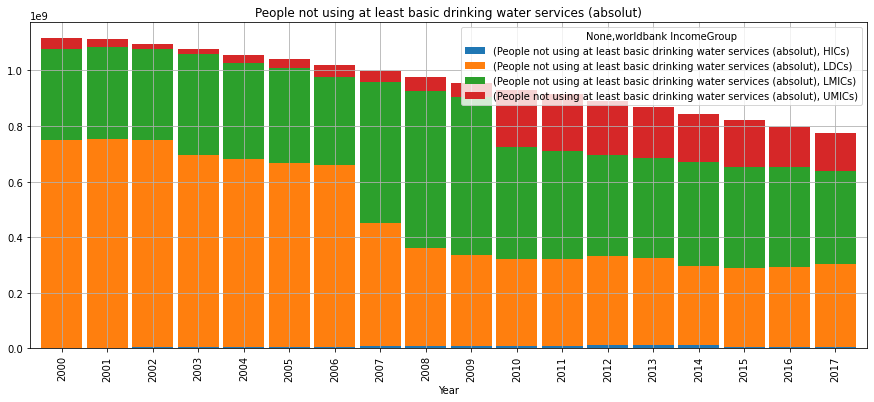

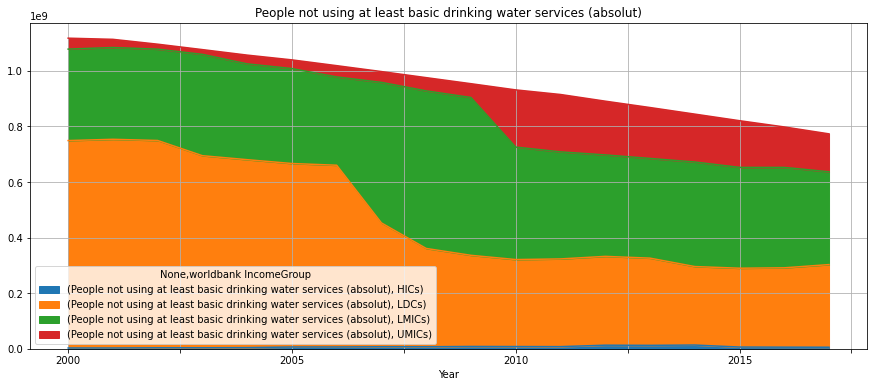

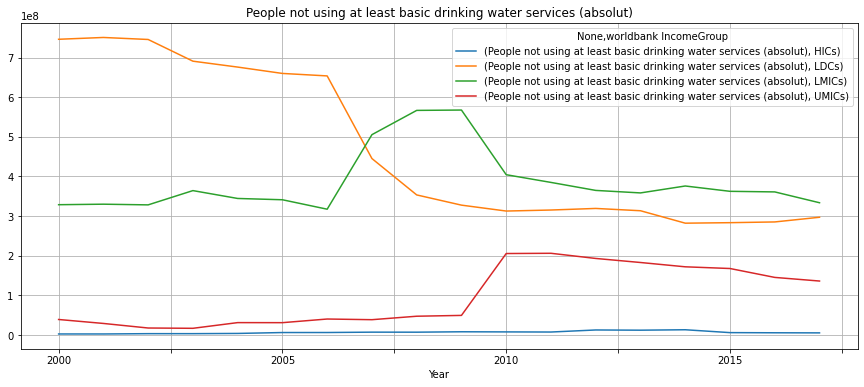

In [8]:
i = 'People using at least basic drinking water services (absolut)' 
j = 'People not using at least basic drinking water services (absolut)'
k = 'Population, total'
l = 'People using at least basic drinking water services (% of population)'
m = 'People not using at least basic drinking water services (% of population)'

df[i] = df[l] * df[k] / 100
df[m] = 100 - df[l]
tmp = df[['Year','worldbank IncomeGroup',i,k]].copy()
tmp.replace({i: {0.0: np.nan}},inplace=True)
tmp[j] = tmp[k] - tmp[i]
tmp = tmp[~tmp[j].isnull()]

tmp = tmp[tmp['Year'].isin(list(map(lambda x: str(x),range(2000,2019))))]

#tmp = tmp[tmp['worldbank IncomeGroup'].isin(['LMICs','LDCs','UMICs'])]
tmp_agg = tmp[['Year',j,'worldbank IncomeGroup']].groupby(['Year','worldbank IncomeGroup']).sum()
#display(tmp_agg)
tmp_agg.unstack().plot(width=0.9,grid=True,stacked=True,kind='bar',title=j,figsize=(15,6))
tmp_agg.unstack().plot(grid=True,stacked=True,kind='area',title=j,figsize=(15,6))
tmp_agg.unstack().plot(grid=True,title=j,figsize=(15,6))

<AxesSubplot:title={'center':'Population, total'}, xlabel='Year'>

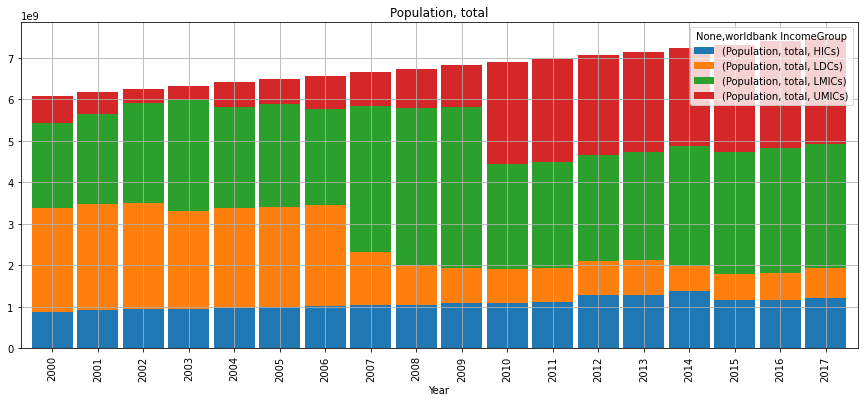

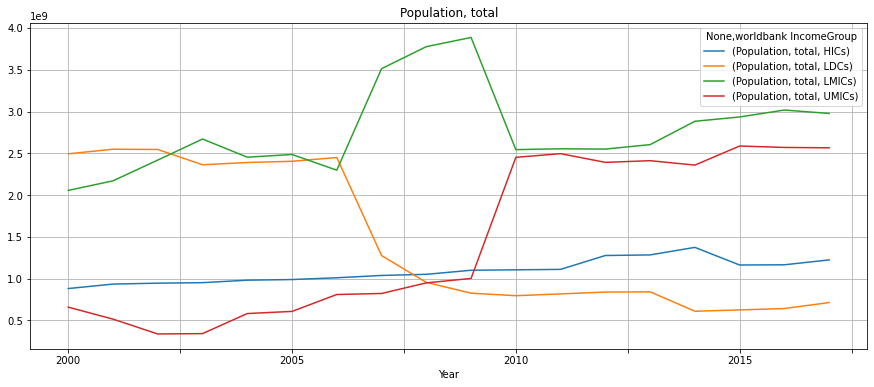

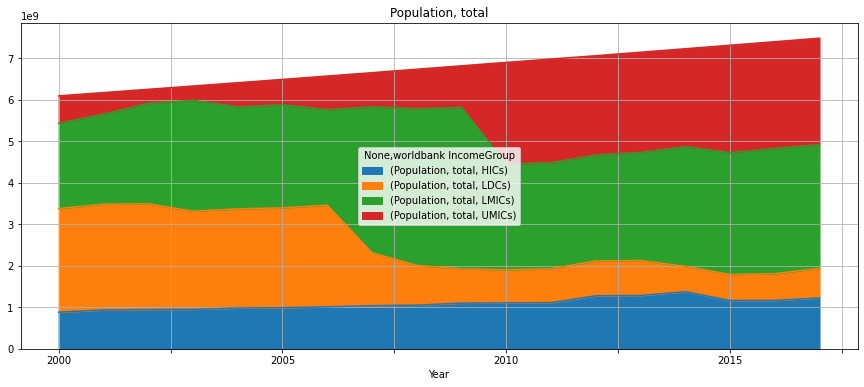

In [9]:
tmp = df[['Year','worldbank IncomeGroup',k]].copy()
tmp = tmp[tmp['Year'].isin(list(map(lambda x: str(x),range(2000,2018))))]
tmp.replace({k: {0.0: np.nan}},inplace=True)
tmp = tmp[~tmp[k].isnull()]
#tmp = tmp[tmp['worldbank IncomeGroup'].isin(['LMICs','LDCs','UMICs'])]
tmp_agg = tmp.groupby(['Year','worldbank IncomeGroup']).sum()
#display(tmp_agg)
tmp_agg.unstack().plot(width=0.9,grid=True,stacked=True,kind='bar',title=k,figsize=(15,6))
tmp_agg.unstack().plot(grid=True,title=k,figsize=(15,6))
tmp_agg.unstack().plot(grid=True,stacked=True,kind='area',title=k,figsize=(15,6))

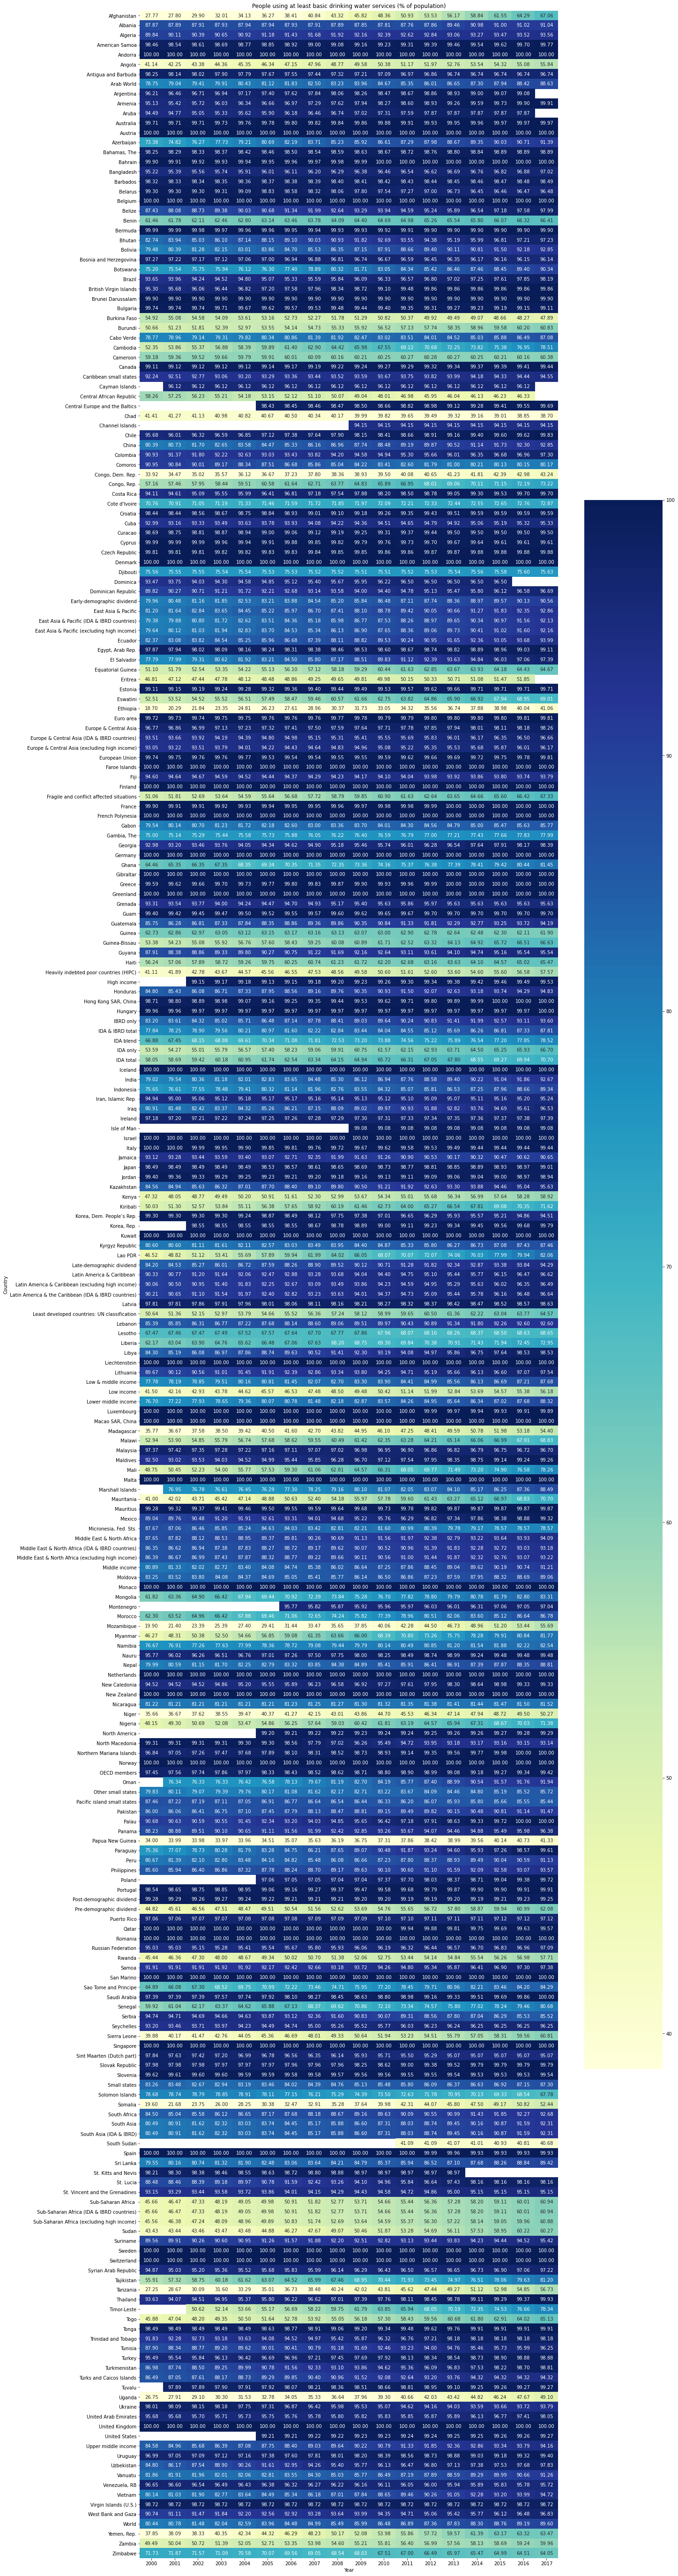

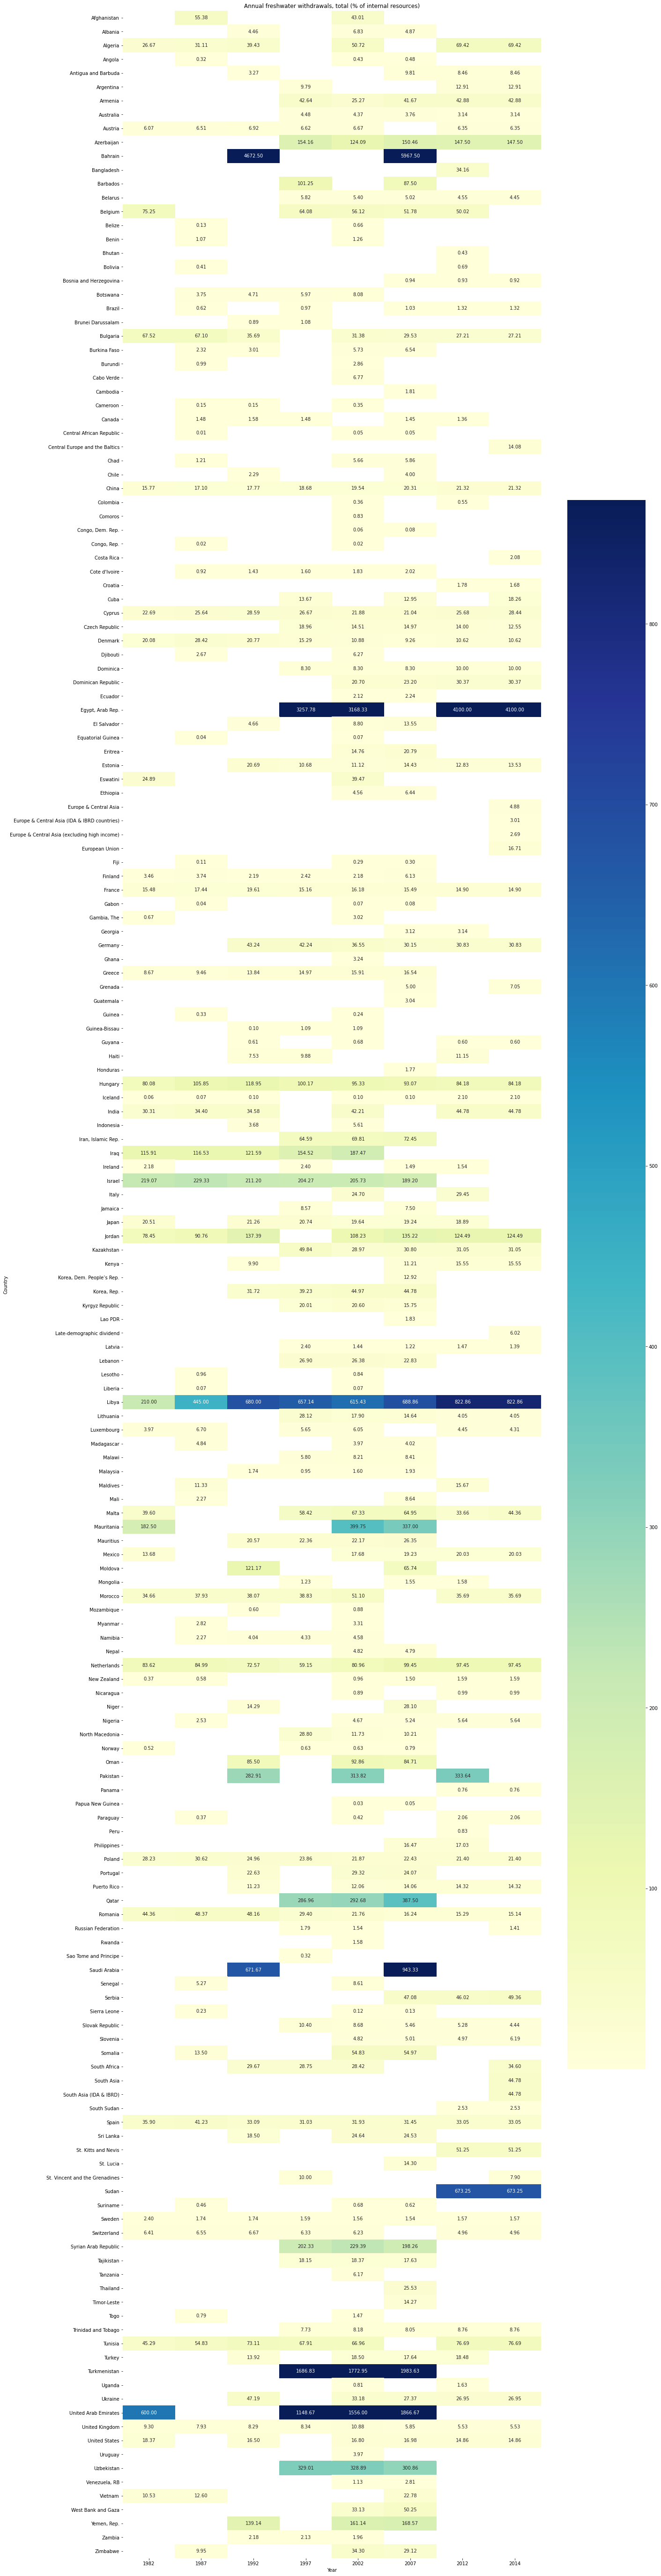

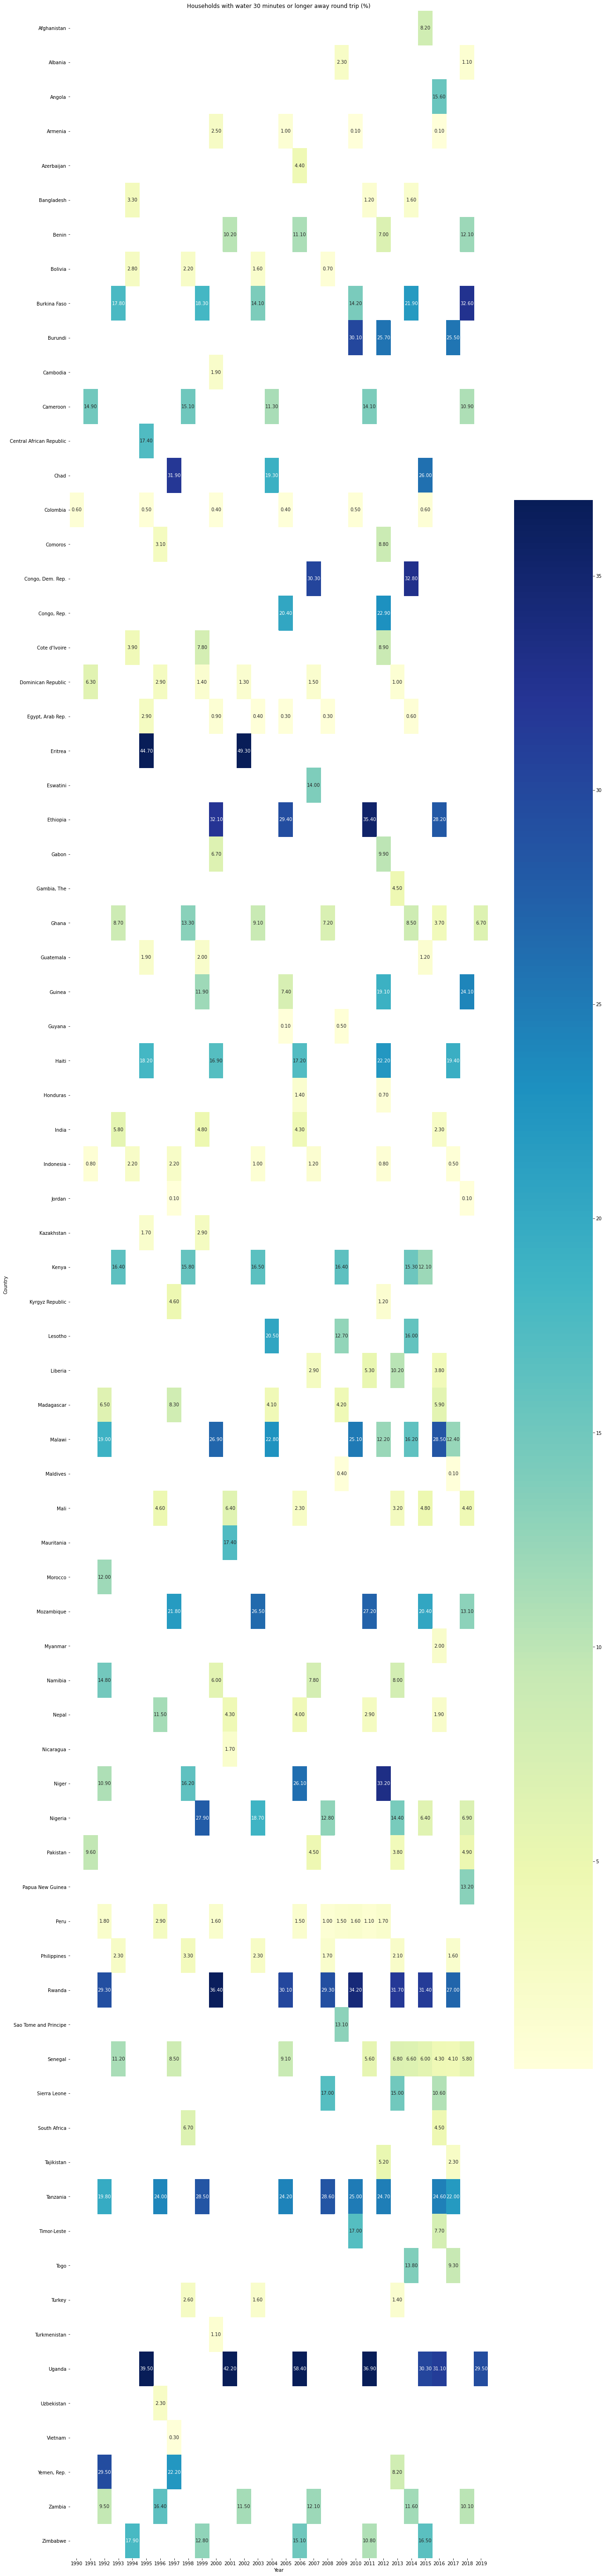

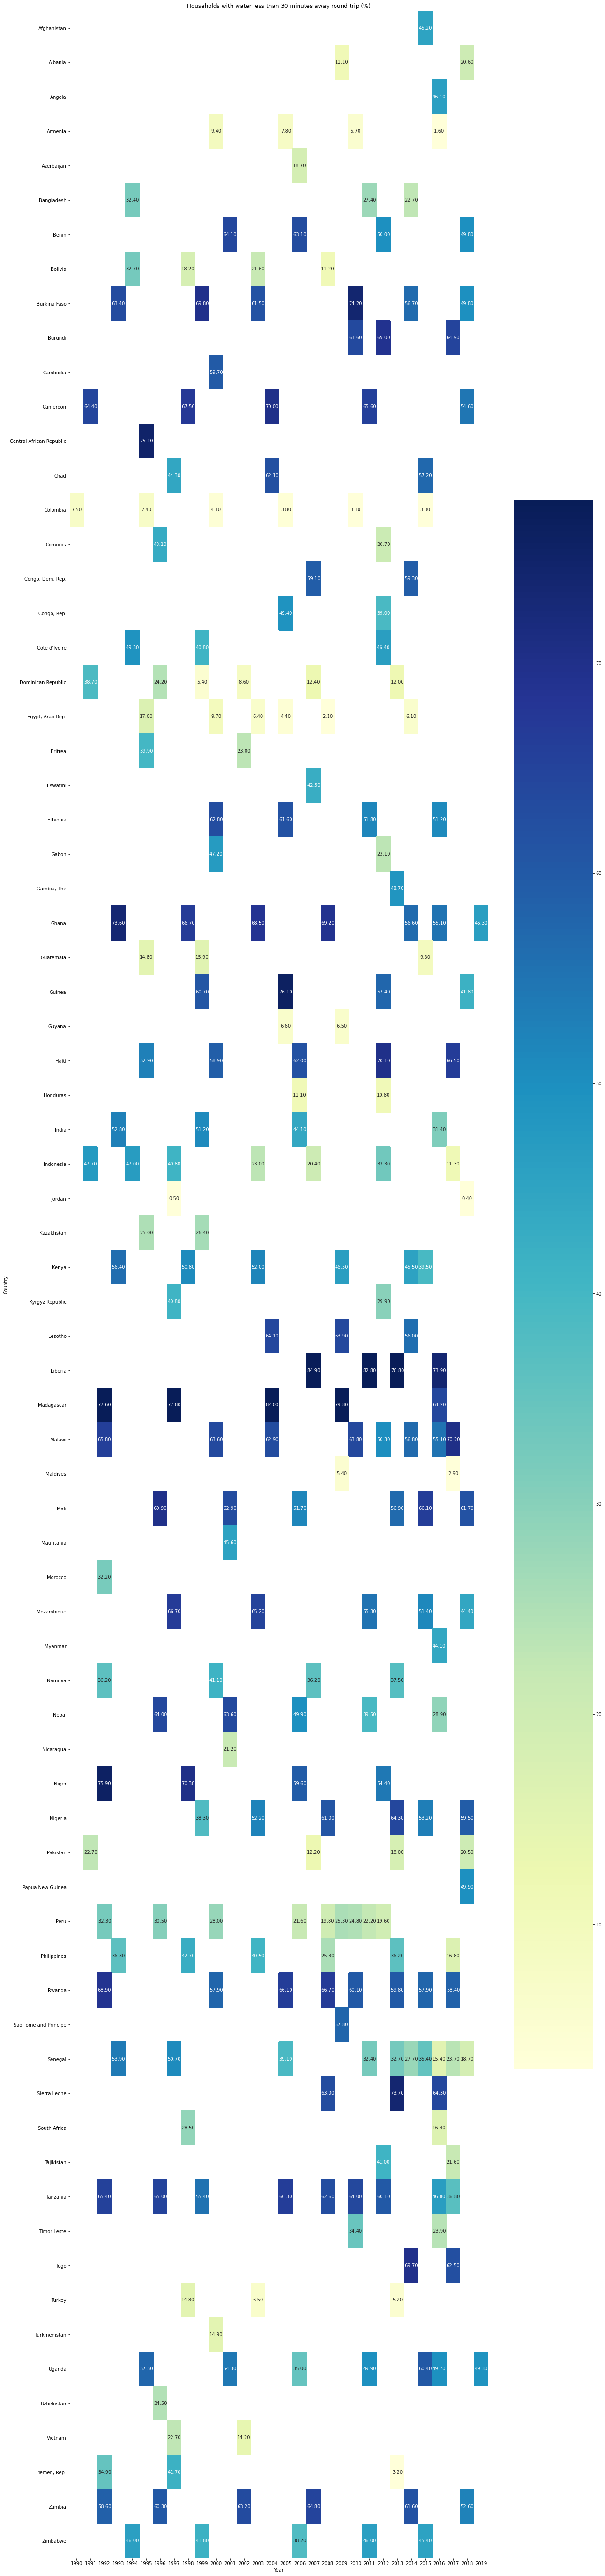

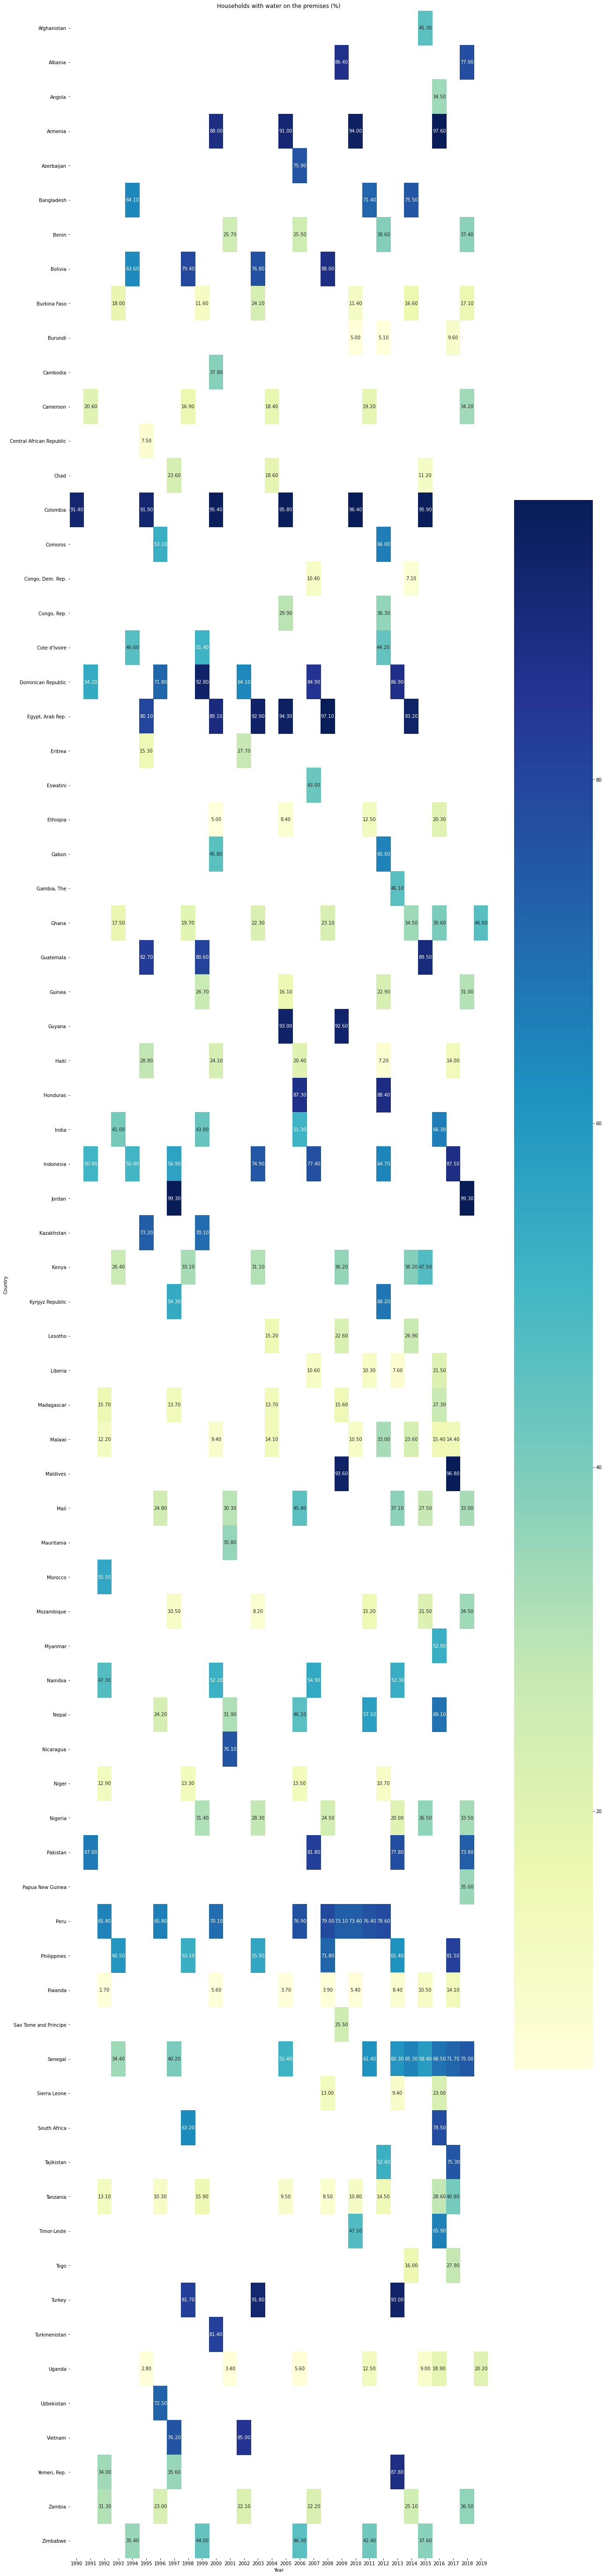

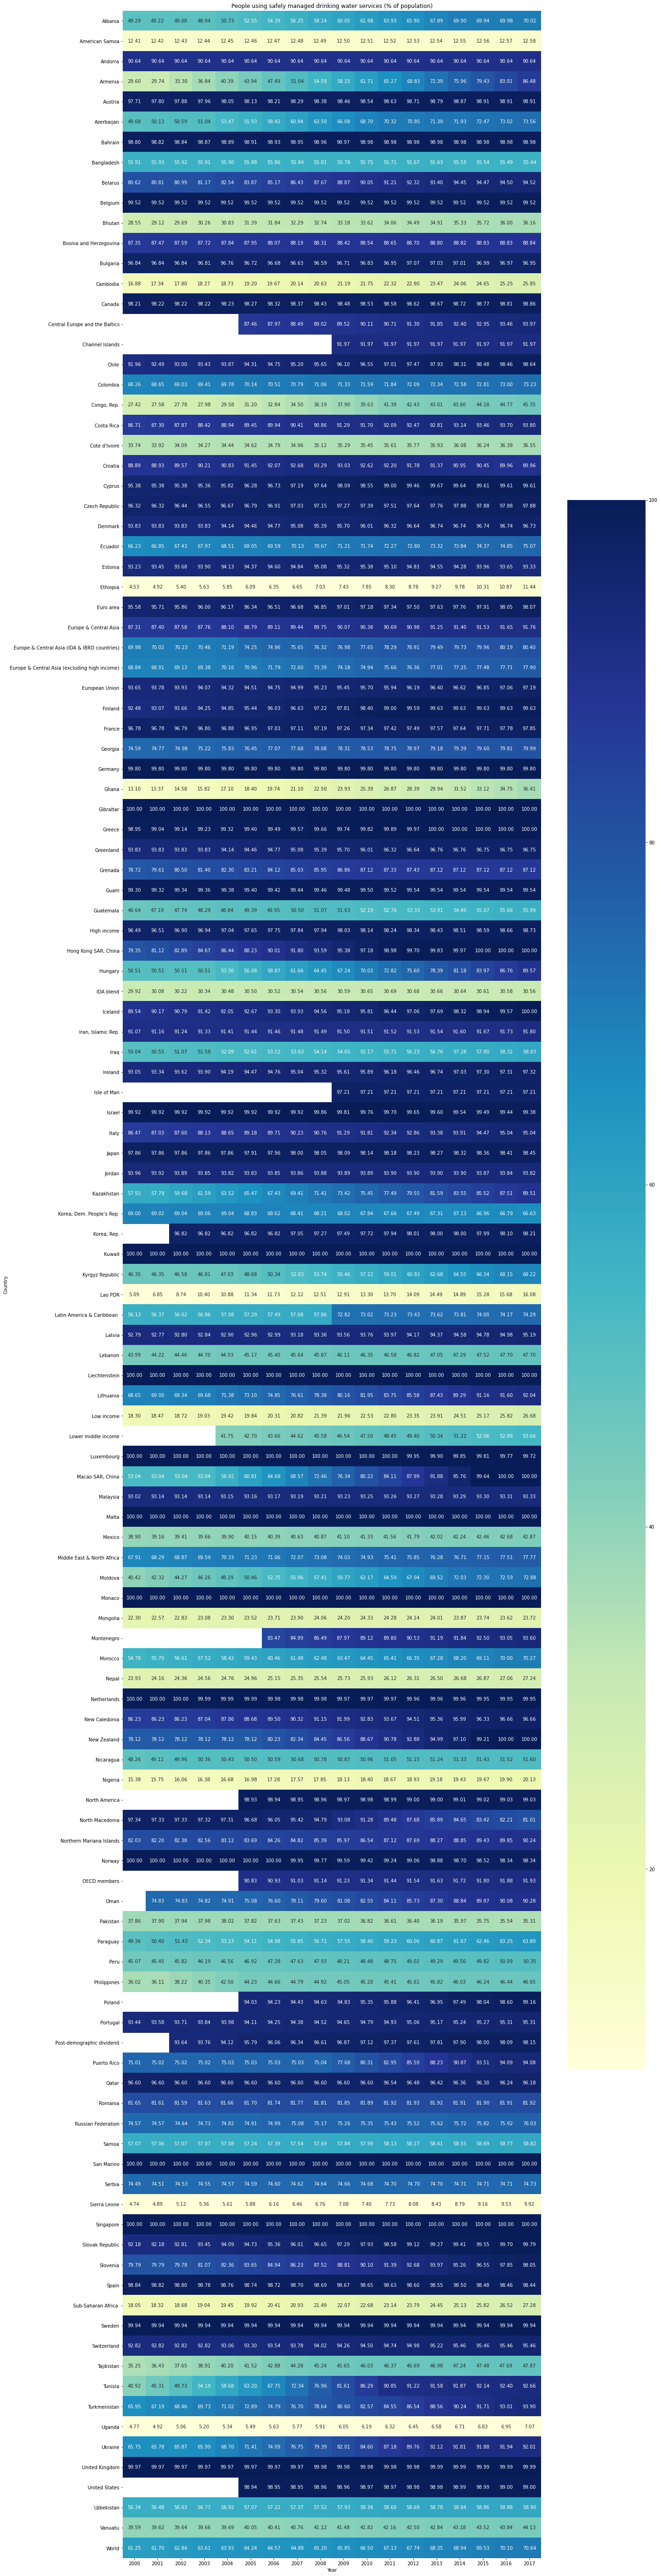

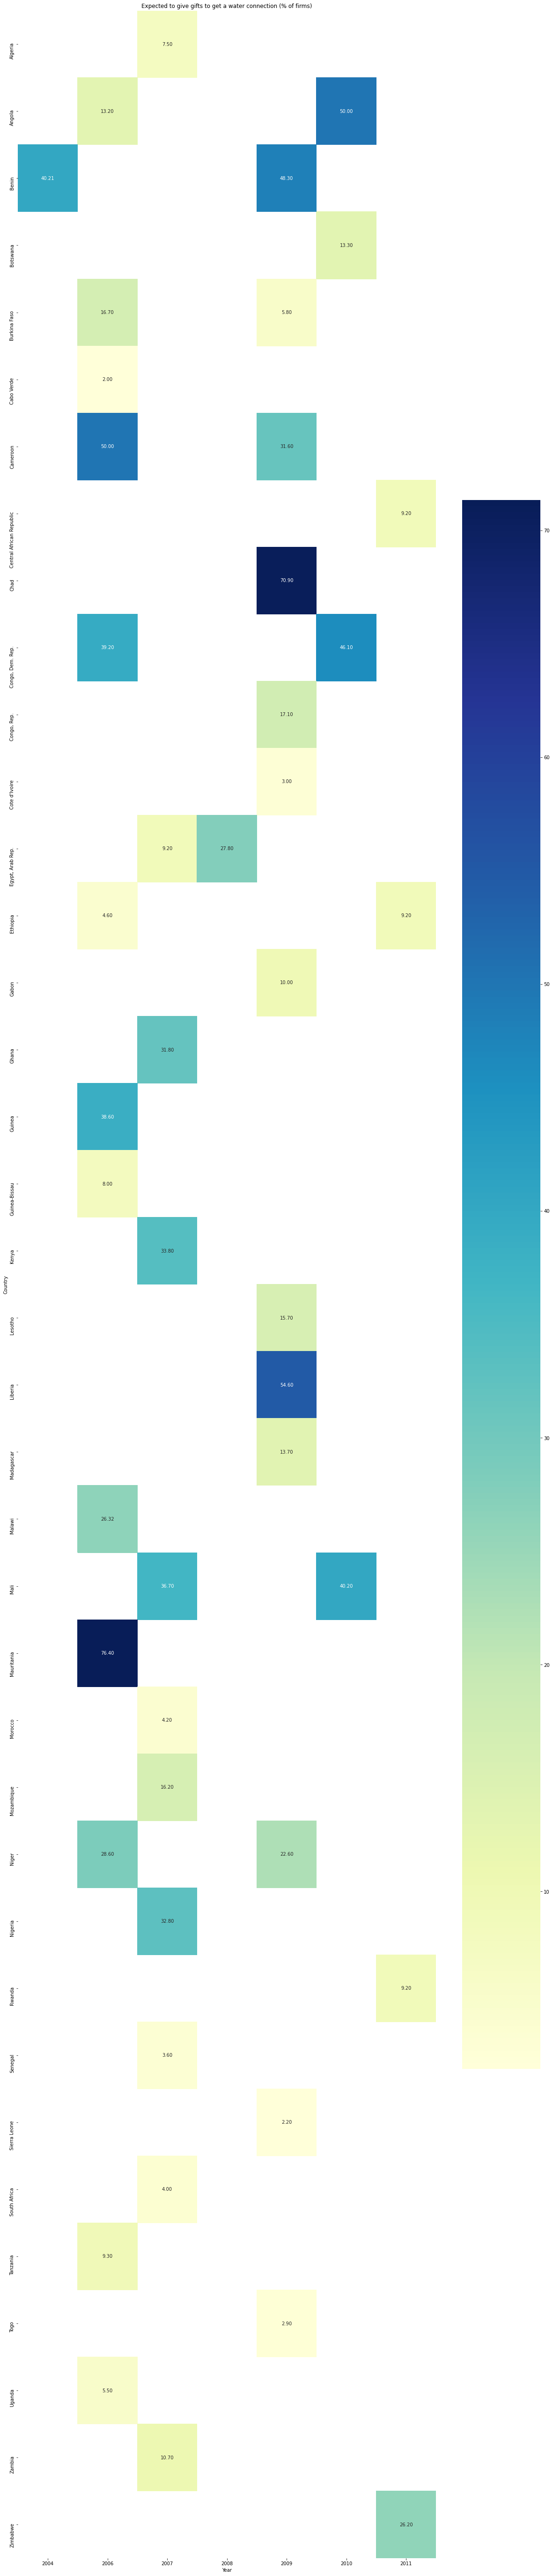

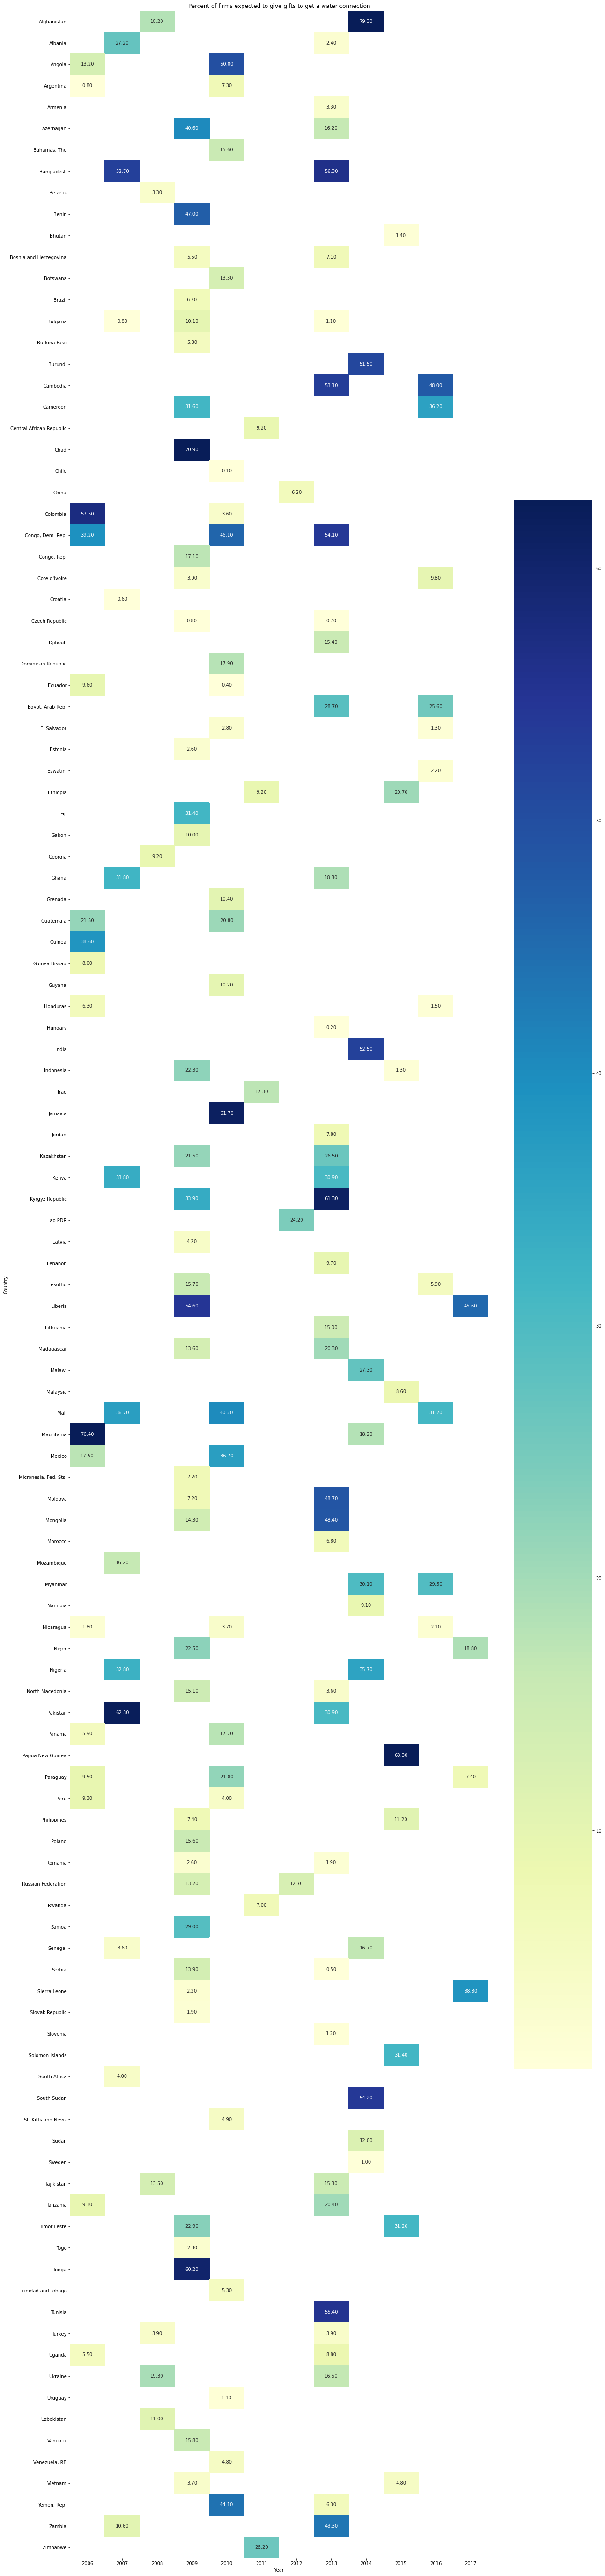

In [10]:
%matplotlib inline

for i in ['People using at least basic drinking water services (% of population)',
          'Annual freshwater withdrawals, total (% of internal resources)',
          'Households with water 30 minutes or longer away round trip (%)',
          'Households with water less than 30 minutes away round trip (%)',
          'Households with water on the premises (%)',
          'People using safely managed drinking water services (% of population)',
          'Expected to give gifts to get a water connection (% of firms)',
          'Percent of firms expected to give gifts to get a water connection',
         ]:

    tmp = df[['Country','Year',i]].copy()

    #display(tmp['People using at least basic drinking water services (% of population)'])
    tmp.replace({i: {0.0: np.nan}},inplace=True)
    tmp = tmp[~tmp[i].isnull()]
    #display(tmp.describe())
    tmp2 = tmp.pivot(index='Country', columns='Year', values=i)
    #display(tmp.groupby(['Country']).count())
    #tmp = tmp.set_index('Country')
    #tmp2.style.background_gradient(cmap='Blues')

    fig, ax = plt.subplots(figsize=(20,100)) 
    ax.set_title(i)
    sns.heatmap(tmp2, annot=True,ax=ax,fmt=".2f",cmap="YlGnBu",robust=True)